In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *

In [4]:
root = '../../..'
data_path = os.path.join(root, 'Data')
esm3_path = os.path.join(data_path, 'esm3_experiments/mi_exp')
evodiff_path = os.path.join(data_path, 'evodiff_experiments/mi_exp')

#### Merging all fasta files

In [5]:
# seq_dict = {}
# size = 0
# for f in os.listdir(esm3_path):
#     file = os.path.join(esm3_path, f)
#     records = helper.read_fasta(file)
#     for rec in records:
#         seq_dict[f'gxps_ATC_esm3_temp_0.5_gen_{size}'] = str(rec.seq)
#         size += 1

#         if size == 100000:
#             break

In [6]:
# fasta_file = os.path.join(esm3_path, 'ems3_mi_compiled.fasta')
# helper.create_fasta(seq_dict, fasta_file)

In [7]:
# seq_dict = {}
# size = 0
# for f in os.listdir(evodiff_path):
#     file = os.path.join(evodiff_path, f)
#     records = helper.read_fasta(file)
#     for rec in records:
#         seq_dict[f'gxps_ATC_evodiff_gen_{size}'] = str(rec.seq)
#         size += 1

In [8]:
# fasta_file = os.path.join(evodiff_path, 'evodiff_mi_compiled.fasta')
# helper.create_fasta(seq_dict, fasta_file)

#### Entropy Calculation

In [9]:
esm3_fasta = os.path.join(esm3_path, 'ems3_mi_compiled.fasta')
evodiff_fasta = os.path.join(evodiff_path, 'evodiff_mi_compiled.fasta')

esm3_records = helper.read_fasta(esm3_fasta)
evodiff_records = helper.read_fasta(evodiff_fasta)

assert len(esm3_records) == len(evodiff_records) == 100000

In [10]:
gxps_wt_protein = BaseProtein(file='/nethome/kgeorge/workspace/DomainPrediction/Data/gxps/gxps_ATC_hm_6mfy.pdb')

In [11]:
def calculate_drift(records, wt_protein: BaseProtein):
    counts = []
    collection = set()
    for rec in records:
        _protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
        
        assert wt_protein.get_residues(A_gxps_atc) == _protein.get_residues(A_gxps_atc)
        assert wt_protein.get_residues(C_gxps_atc) == _protein.get_residues(C_gxps_atc)

        collection.add(_protein.get_residues(T_gxps_atc))
        counts.append(len(collection))

    return counts, collection

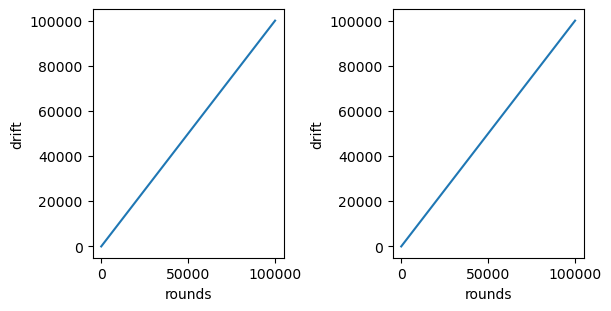

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), layout='constrained')

counts, _ = calculate_drift(esm3_records, gxps_wt_protein)
ax[0].plot(counts)
ax[0].set_xlabel('rounds')
ax[0].set_ylabel('drift')

counts, _ = calculate_drift(evodiff_records, gxps_wt_protein)
ax[1].plot(counts)
ax[1].set_xlabel('rounds')
ax[1].set_ylabel('drift')

plt.show()

In [13]:
def get_Tdomains(records):
    sequences = []
    for rec in records:
        _protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
        sequences.append(_protein.get_residues(T_gxps_atc))
    
    return sequences 

In [14]:
esm3_Tdomains = get_Tdomains(esm3_records)
evodiff_Tdomains = get_Tdomains(evodiff_records)

In [15]:
seq_len = len(gxps_wt_protein.get_residues(T_gxps_atc))
for t1, t2 in zip(esm3_Tdomains, evodiff_Tdomains):
    assert len(t1) == len(t2) == seq_len

In [16]:
from collections import Counter, defaultdict
from math import log2

In [17]:
def get_entropies(Tdomains):
    entropies = []
    for i in range(seq_len):
        column = [seq[i] for seq in Tdomains]

        counts = Counter(column)
        total = sum(counts.values())
        frequencies = [count / total for count in counts.values()]
        entropy = -sum(f * log2(f) for f in frequencies)
        entropies.append(entropy)

    return entropies

In [18]:
esm3_entropies = get_entropies(esm3_Tdomains)
evodiff_entropies = get_entropies(evodiff_Tdomains)

In [19]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

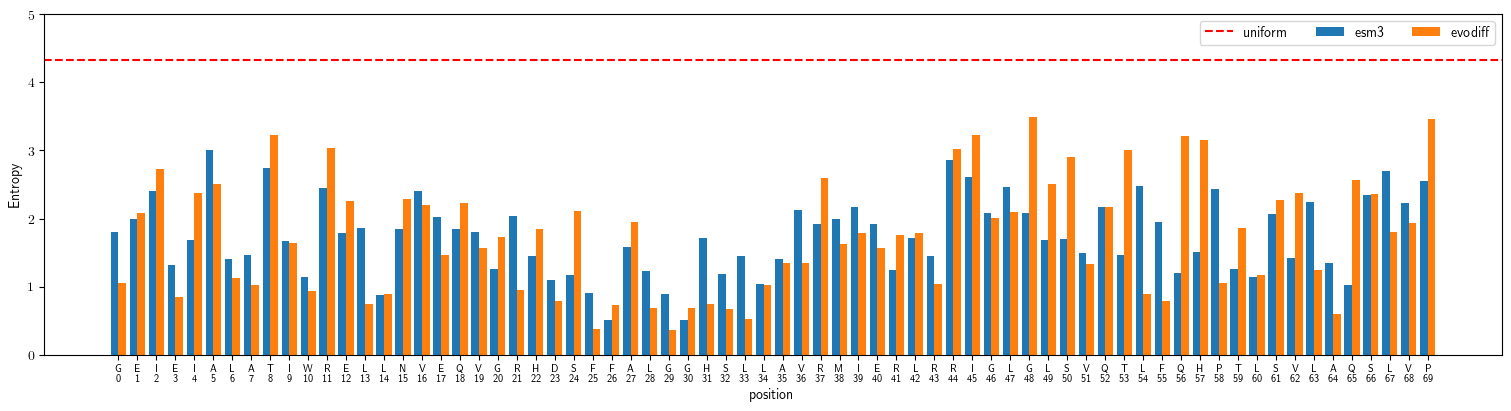

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15,4), layout='constrained')

width = 0.4
x = np.arange(seq_len)
ax.bar(x, esm3_entropies, width, label='esm3')
ax.bar(x+width, evodiff_entropies, width, label='evodiff')
ax.axhline(y=log2(20), linestyle='--', color='red', label='uniform')

ax.set_xticks(x+width/2)
# ax.set_xticklabels([f"{_aa}$_{{{_pos}}}$" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=7)
ax.set_xticklabels([f"{_aa}\n{_pos}" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=7)
ax.set_xlabel('position')
ax.set_ylabel('Entropy')
ax.set_ylim(top=5)
ax.legend(ncol=3)

plt.show()

In [21]:
2**sum(evodiff_entropies), 2**sum(esm3_entropies)

(9.20915339557625e+36, 5.494749127040761e+36)

#### Probability matrix

In [22]:
def get_freq_matrix(Tdomains, seq_length):
    aa_freq = {
        'A' : [],
        'R' : [],
        'N' : [],
        'D' : [],
        'C' : [],
        'Q' : [],
        'E' : [],
        'G' : [],
        'H' : [],
        'I' : [],
        'L' : [],
        'K' : [],
        'M' : [],
        'F' : [],
        'P' : [],
        'S' : [],
        'T' : [],
        'W' : [],
        'Y' : [],
        'V' : [],
    }
    for i in range(seq_length):
        column = [seq[i] for seq in Tdomains]

        counts = Counter(column)
        total = sum(counts.values())
        frequencies = {aa : count / total for aa, count in counts.items()}
        
        for aa in aa_freq:
            if aa in frequencies:
                aa_freq[aa].append(frequencies[aa])
            else:
                aa_freq[aa].append(0)

    return pd.DataFrame(aa_freq).T

In [23]:
esm3_freq_matrix = get_freq_matrix(esm3_Tdomains, seq_len)
evodiff_freq_matrix = get_freq_matrix(evodiff_Tdomains, seq_len)

In [24]:
thresh = 0.01
esm3_freq_matrix_filtered = esm3_freq_matrix.map(lambda x: x if x >= thresh else 0)
evodiff_freq_matrix_filtered = evodiff_freq_matrix.map(lambda x: x if x >= thresh else 0)

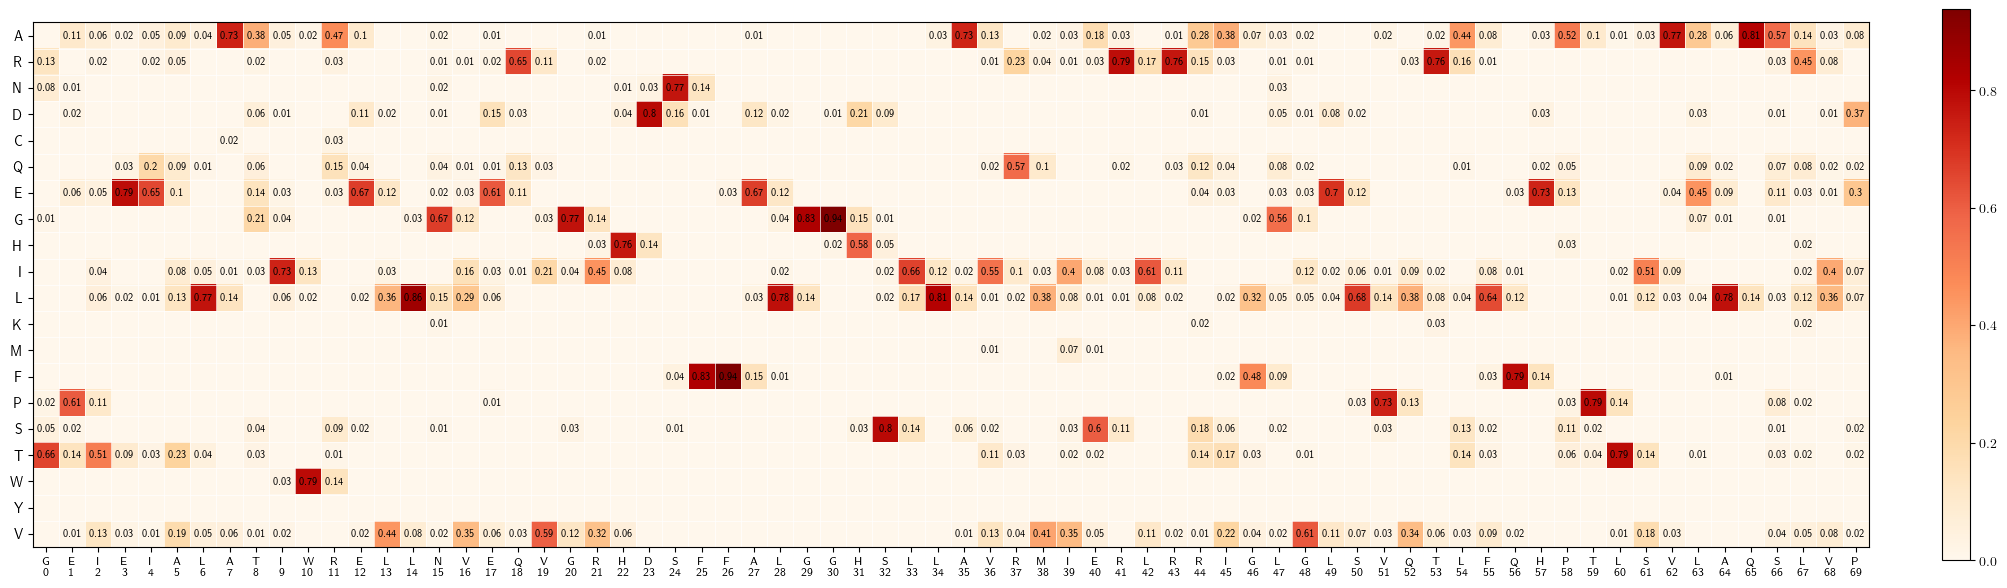

In [25]:
fig, ax = plt.subplots(figsize=(20,10), layout='constrained')
im = ax.imshow(esm3_freq_matrix_filtered, cmap="OrRd")
ax.set_xticks(np.arange(0, 70))
ax.set_xticklabels([f"{_aa}\n{_pos}" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=8)
ax.set_yticks(np.arange(len(esm3_freq_matrix_filtered.index)), labels=esm3_freq_matrix_filtered.index)
ax.figure.colorbar(im, ax=ax, fraction=0.015, pad=0.04)
plt.hlines(y=np.arange(0, 20)+0.5, xmin=np.full(20, 0)-0.5, xmax=np.full(20, 70)-0.5, color="w", linewidth=0.5)
plt.vlines(x=np.arange(0, 70)+0.5, ymin=np.full(70, 0)-0.5, ymax=np.full(70, 20)-0.5, color="w", linewidth=0.5)

for i in range(esm3_freq_matrix_filtered.shape[0]):
    for j in range(esm3_freq_matrix_filtered.shape[1]):
        if esm3_freq_matrix_filtered.iloc[i, j] > 0:
            text = ax.text(j, i, round(esm3_freq_matrix_filtered.iloc[i, j],2),
                        ha="center", va="center", color="k", size=7)
plt.show()

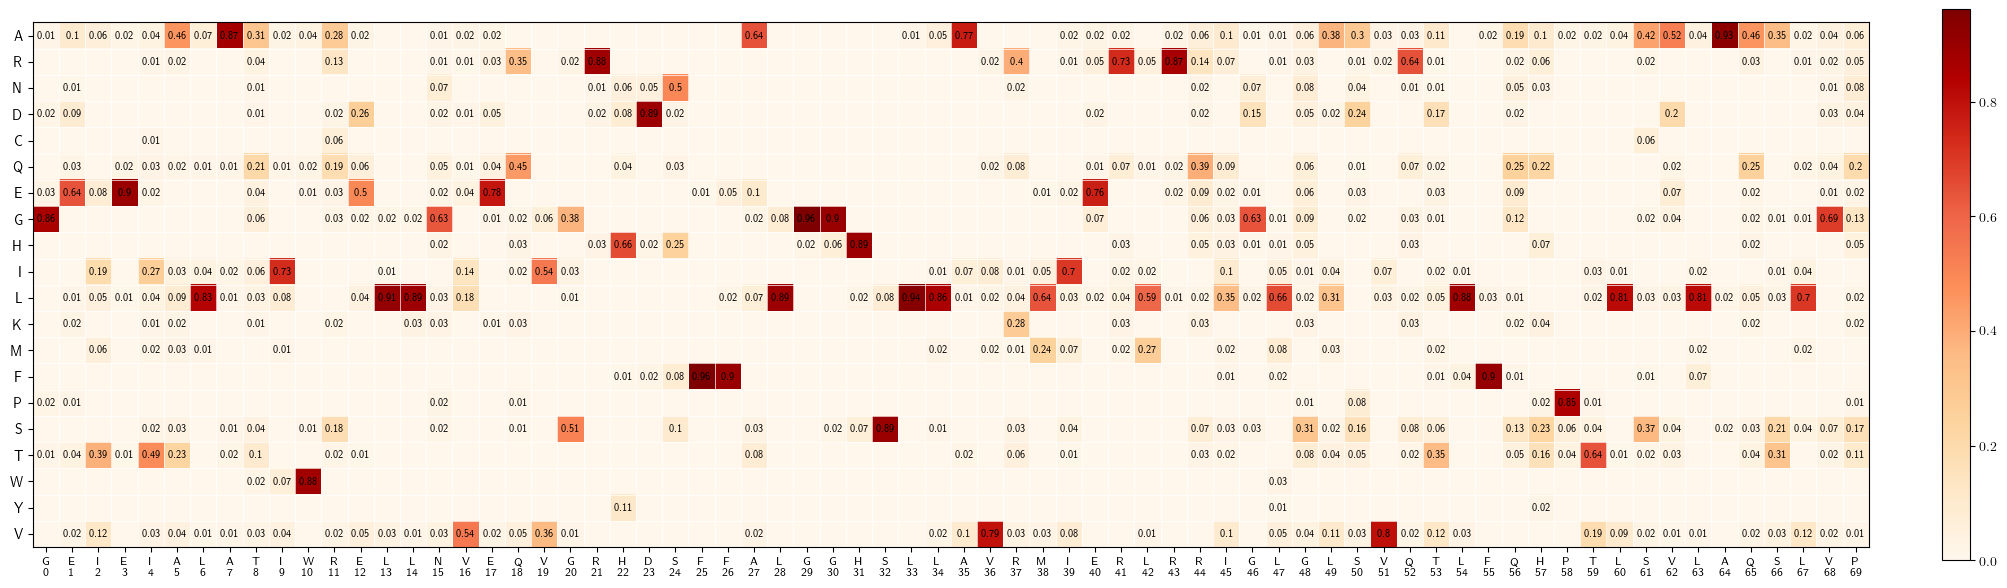

In [26]:
fig, ax = plt.subplots(figsize=(20,10), layout='constrained')
im = ax.imshow(evodiff_freq_matrix_filtered, cmap="OrRd")
ax.set_xticks(np.arange(0, 70))
ax.set_xticklabels([f"{_aa}\n{_pos}" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=8)
ax.set_yticks(np.arange(len(evodiff_freq_matrix_filtered.index)), labels=evodiff_freq_matrix_filtered.index)
ax.figure.colorbar(im, ax=ax, fraction=0.015, pad=0.04)
plt.hlines(y=np.arange(0, 20)+0.5, xmin=np.full(20, 0)-0.5, xmax=np.full(20, 70)-0.5, color="w", linewidth=0.5)
plt.vlines(x=np.arange(0, 70)+0.5, ymin=np.full(70, 0)-0.5, ymax=np.full(70, 20)-0.5, color="w", linewidth=0.5)

for i in range(evodiff_freq_matrix_filtered.shape[0]):
    for j in range(evodiff_freq_matrix_filtered.shape[1]):
        if evodiff_freq_matrix_filtered.iloc[i, j] > 0:
            text = ax.text(j, i, round(evodiff_freq_matrix_filtered.iloc[i, j],2),
                        ha="center", va="center", color="k", size=7)
plt.show()

#### Mutual Information

In [27]:
def mi(a, b, ab):
    return ab*log2(ab/(a*b))

def get_frequencies(column):
    counts = Counter(column)
    total = sum(counts.values())
    frequencies = {aa : count / total for aa, count in counts.items()}

    return frequencies

In [28]:
def get_mi_matrix(Tdomains, seq_length):
    MI_matrix = np.zeros((seq_length, seq_length))
    for i in tqdm(range(seq_length)):
        for j in range(i+1, seq_length):
            column_i = [seq[i] for seq in Tdomains]
            column_j = [seq[j] for seq in Tdomains]
            column_ij = [seq[i]+seq[j] for seq in Tdomains]

            frequencies_i = get_frequencies(column_i)
            frequencies_j = get_frequencies(column_j)
            frequencies_ij = get_frequencies(column_ij)

            MI = 0
            for ab in frequencies_ij:
                MI += mi(frequencies_i[ab[0]], frequencies_j[ab[1]], frequencies_ij[ab])

            MI_matrix[j, i] = MI
            # MI_matrix[i, j] = MI

    return MI_matrix

In [29]:
esm3_mi_matrix = get_mi_matrix(esm3_Tdomains, seq_len)
evodiff_mi_matrix = get_mi_matrix(evodiff_Tdomains, seq_len)

100%|██████████| 70/70 [01:00<00:00,  1.15it/s]


In [37]:
import matplotlib.colors as mcolors

In [38]:
def plot_mi_matrix(mi_matrix):
    fig, ax = plt.subplots(figsize=(15,15), layout="constrained")

    matrix = mi_matrix.copy()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    # mask = np.tril(np.ones_like(matrix, dtype=bool))
    matrix[mask] = np.nan

    norm = mcolors.Normalize(vmin=0, vmax=1)
    im = ax.imshow(matrix, cmap="OrRd", norm=norm)
    # im = ax.imshow(matrix, cmap="magma")

    ax.set_xticks(np.arange(0, 70))
    ax.set_yticks(np.arange(0, 70))
    ax.set_xticklabels([f"{_aa}\n{_pos}" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=8)
    ax.set_yticklabels([f"{_aa}{_pos}" for _aa, _pos in zip(gxps_wt_protein.get_residues(T_gxps_atc), np.arange(seq_len))], size=8)
    ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

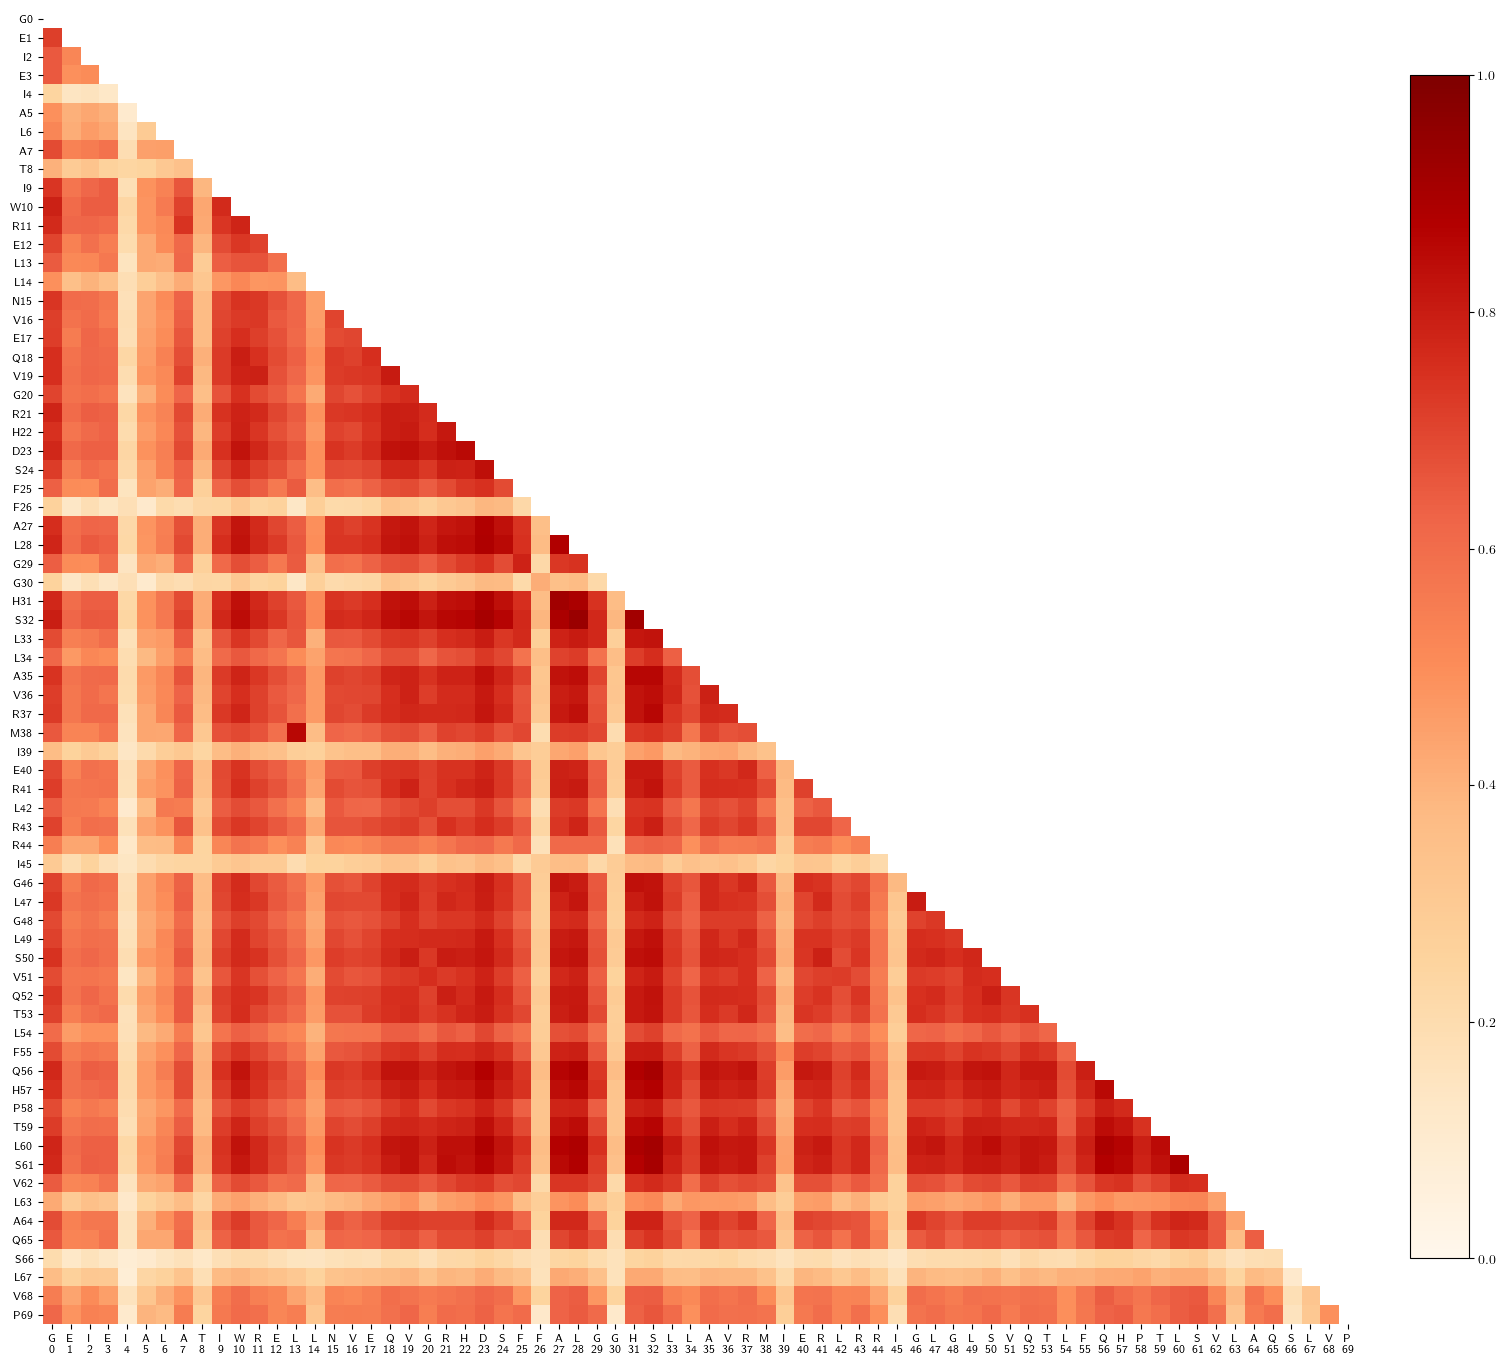

In [39]:
plot_mi_matrix(esm3_mi_matrix)

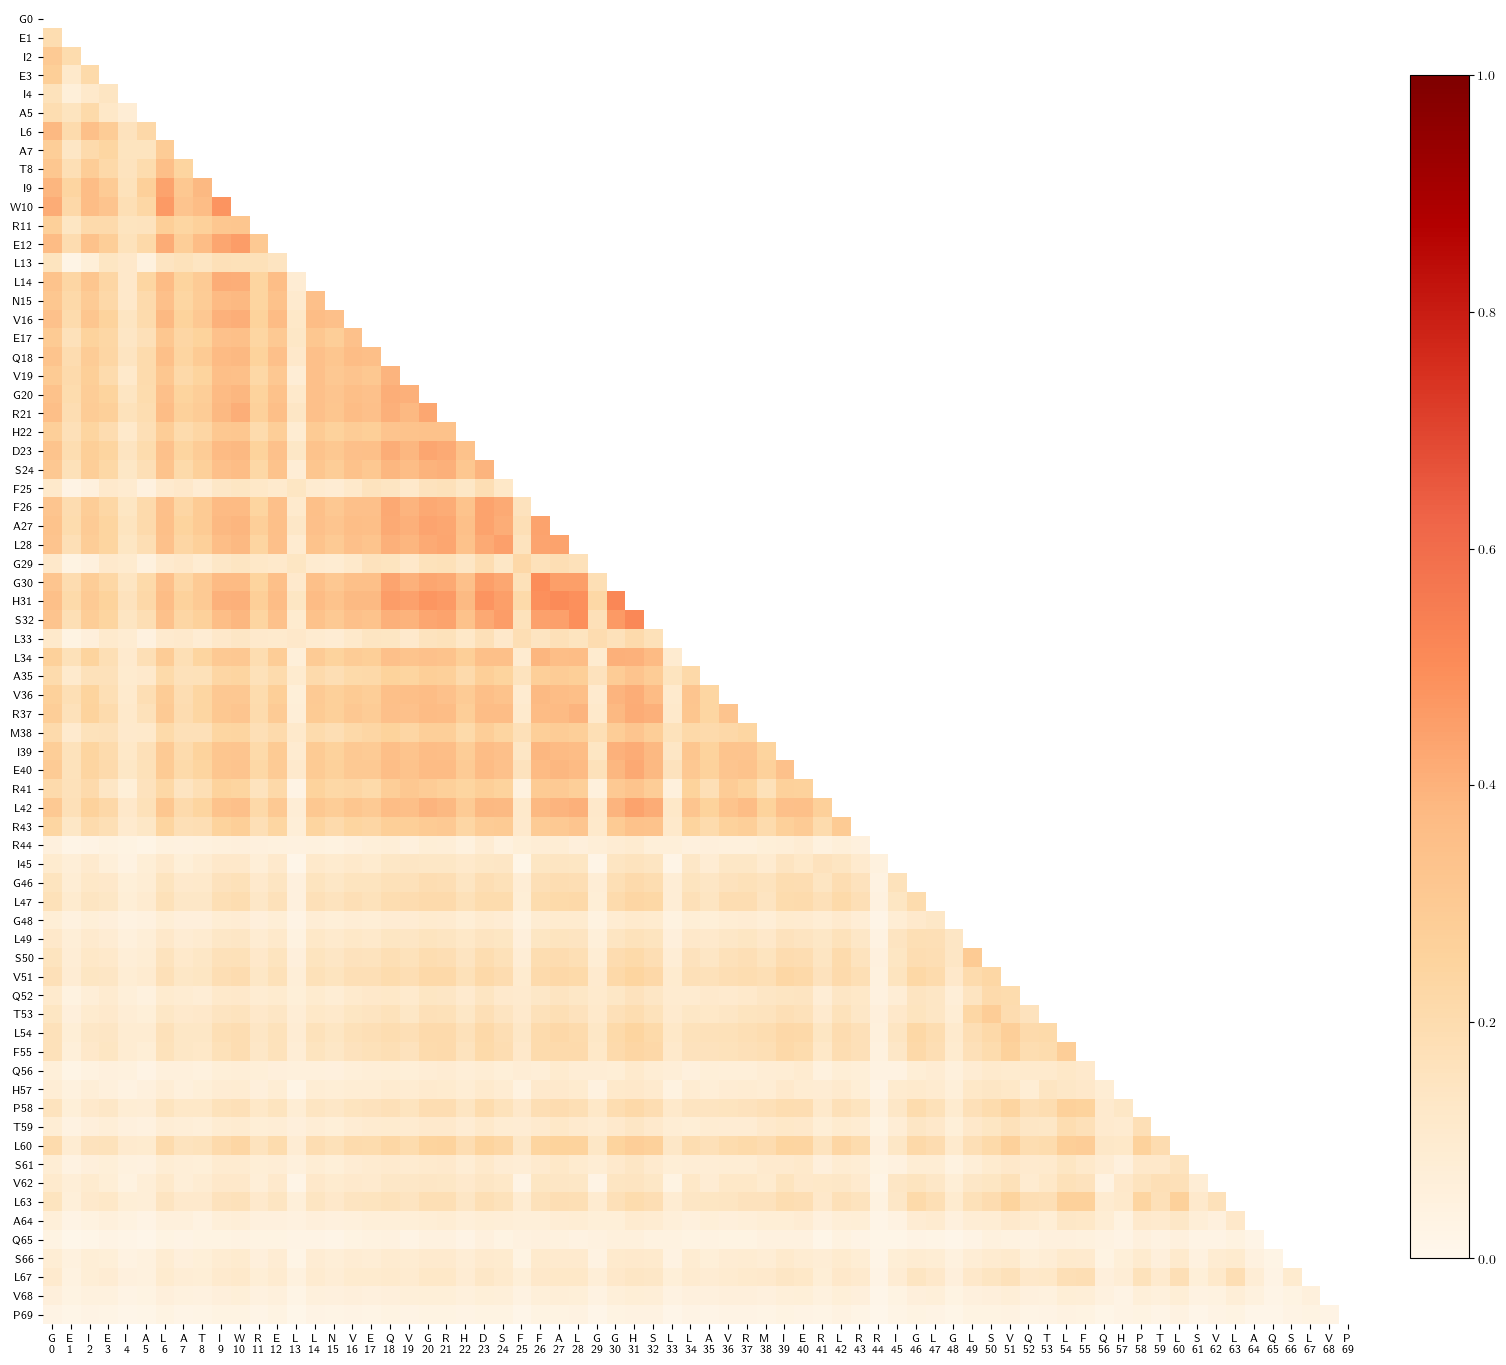

In [40]:
plot_mi_matrix(evodiff_mi_matrix)

In [33]:
# Number of top values to find
top_n = 10
flattened_matrix = esm3_mi_matrix.flatten()
top_indices_flat = np.argpartition(flattened_matrix, -top_n)[-top_n:]
top_indices_flat = top_indices_flat[np.argsort(flattened_matrix[top_indices_flat], )][::-1]
np.unravel_index(top_indices_flat, esm3_mi_matrix.shape)

(array([32, 31, 32, 60, 32, 56, 61, 31, 32, 61]),
 array([28, 27, 31, 32, 23, 32, 32, 28, 27, 60]))

In [34]:
# Number of top values to find
top_n = 10
flattened_matrix = evodiff_mi_matrix.flatten()
top_indices_flat = np.argpartition(flattened_matrix, -top_n)[-top_n:]
top_indices_flat = top_indices_flat[np.argsort(flattened_matrix[top_indices_flat], )][::-1]
np.unravel_index(top_indices_flat, evodiff_mi_matrix.shape)

(array([31, 32, 31, 30, 32, 31, 31, 31, 10, 31]),
 array([30, 31, 27, 26, 28, 28, 26, 23,  9, 20]))

#### MI component

In [132]:
def get_mi_data(Tdomains, seq_length):
    MI_data = []
    for i in tqdm(range(seq_length)):
        for j in range(i+1, seq_length):
            column_i = [seq[i] for seq in Tdomains]
            column_j = [seq[j] for seq in Tdomains]
            column_ij = [seq[i]+seq[j] for seq in Tdomains]

            frequencies_i = get_frequencies(column_i)
            frequencies_j = get_frequencies(column_j)
            frequencies_ij = get_frequencies(column_ij)

            for ab in frequencies_ij:
                dp = (i, j, ab[0], ab[1], ab, frequencies_i[ab[0]], frequencies_j[ab[1]], frequencies_ij[ab], mi(frequencies_i[ab[0]], frequencies_j[ab[1]], frequencies_ij[ab]))
                MI_data.append(dp)

    return MI_data

In [133]:
esm3_mi_data = get_mi_data(esm3_Tdomains, seq_len)
evodiff_mi_data = get_mi_data(evodiff_Tdomains, seq_len)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:57<00:00,  1.23it/s]


In [134]:
esm3_mi_data_sorted = sorted(esm3_mi_data, key=lambda k: k[8], reverse=True)
evodiff_mi_data_sorted = sorted(evodiff_mi_data, key=lambda k: k[8], reverse=True)

In [135]:
len(esm3_mi_data_sorted)

528169

In [136]:
for dp in esm3_mi_data_sorted[:20]:
    print(dp)

(27, 31, 'F', 'G', 'FG', 0.14728, 0.14704, 0.1464, 0.40363555234350196)
(33, 57, 'S', 'F', 'SF', 0.14142, 0.14047, 0.14015, 0.395034025390252)
(57, 60, 'F', 'P', 'FP', 0.14047, 0.14071, 0.13975, 0.3943450780514689)
(33, 60, 'S', 'P', 'SP', 0.14142, 0.14071, 0.14006, 0.39430560428663847)
(57, 61, 'F', 'T', 'FT', 0.14047, 0.14047, 0.1393, 0.39277017625568217)
(33, 61, 'S', 'T', 'ST', 0.14142, 0.14047, 0.13958, 0.3926067323115733)
(60, 61, 'P', 'T', 'PT', 0.14071, 0.14047, 0.13917, 0.3918734158396499)
(11, 33, 'W', 'S', 'WS', 0.14015, 0.14142, 0.13869, 0.3892798011499836)
(11, 57, 'W', 'F', 'WF', 0.14015, 0.14047, 0.13823, 0.38867028409798565)
(11, 60, 'W', 'P', 'WP', 0.14015, 0.14071, 0.13808, 0.387692167307807)
(31, 33, 'G', 'S', 'GS', 0.14704, 0.14142, 0.14057, 0.38755458122192366)
(31, 57, 'G', 'F', 'GF', 0.14704, 0.14047, 0.14017, 0.38723854553155634)
(27, 33, 'F', 'S', 'FS', 0.14728, 0.14142, 0.14056, 0.3871818665546235)
(27, 57, 'F', 'F', 'FF', 0.14728, 0.14047, 0.14016, 0.38686671

In [137]:
for dp in evodiff_mi_data_sorted[:20]:
    print(dp)

(24, 28, 'F', 'G', 'FG', 0.08352, 0.08332, 0.08051, 0.28438061239878043)
(28, 32, 'G', 'L', 'GL', 0.08332, 0.07989, 0.07727, 0.27331069851029605)
(24, 32, 'F', 'L', 'FL', 0.08352, 0.07989, 0.07678, 0.2706072793522901)
(30, 31, 'H', 'S', 'HS', 0.06366, 0.06751, 0.0627, 0.2424504452074148)
(27, 31, 'L', 'S', 'LS', 0.06501, 0.06751, 0.062, 0.23686241499577113)
(28, 31, 'G', 'S', 'GS', 0.08332, 0.06751, 0.06553, 0.23212348936900984)
(24, 31, 'F', 'S', 'FS', 0.08352, 0.06751, 0.06521, 0.23030388367408258)
(19, 31, 'G', 'S', 'GS', 0.06162, 0.06751, 0.0594, 0.2278476616378167)
(27, 30, 'L', 'H', 'LH', 0.06501, 0.06366, 0.05916, 0.22702232514299622)
(31, 32, 'S', 'L', 'SL', 0.06751, 0.07989, 0.06359, 0.22635114544625487)
(28, 30, 'G', 'H', 'GH', 0.08332, 0.06366, 0.0623, 0.22141658962064117)
(2, 9, 'E', 'W', 'EW', 0.08157, 0.06571, 0.06238, 0.22087436468963234)
(24, 30, 'F', 'H', 'FH', 0.08352, 0.06366, 0.06197, 0.2195545844118861)
(19, 30, 'G', 'H', 'GH', 0.06162, 0.06366, 0.05656, 0.21774765